# Playground to test code

We install the environment for our agent which is the miniature version of the Atari environment used in the reference paper

In [4]:
!pip install minatar

Next we write the necessary files which would be required to create and run our agent in the desired environment. They have been specifically hardcoded for the minatar environment and can be modified accordingly.

In [5]:
%%writefile env.py
# -*- coding: utf-8 -*-
from collections import deque
import torch
import numpy as np
from minatar import Environment

class Env():
  def __init__(self, args):
    self.device = args.device
    self.env = Environment(args.game)
    self.num_actions = self.env.num_actions()

    # MinAtar state is (10, 10, C). We need to verify channels.
    self.n_channels = self.env.state_shape()[2]

    # History buffer for stacking frames
    self.window = args.history_length
    self.state_buffer = deque([], maxlen=self.window)
    self.training = True

  def _get_state(self):
    # Convert MinAtar (10, 10, C) boolean -> PyTorch (C, 10, 10) float
    s = self.env.state()
    return torch.tensor(s, dtype=torch.float32, device=self.device).permute(2, 0, 1)

  def _reset_buffer(self):
    # Fill buffer with blank states
    for _ in range(self.window):
      self.state_buffer.append(torch.zeros(self.n_channels, 10, 10, device=self.device))

  def reset(self):
    self.env.reset()
    self._reset_buffer()
    # Get initial state
    observation = self._get_state()
    self.state_buffer.append(observation)
    # Return stacked history: (History, C, 10, 10)
    return torch.stack(list(self.state_buffer), 0)

  def step(self, action):
    reward, done = self.env.act(action)
    observation = self._get_state()
    self.state_buffer.append(observation)
    # Return stacked history, reward, done
    return torch.stack(list(self.state_buffer), 0), reward, done

  def train(self):
    self.training = True

  def eval(self):
    self.training = False

  def action_space(self):
    return self.num_actions

  def render(self):
    pass # MinAtar visualizer doesn't work easily in Colab without specific setups

  def close(self):
    pass

Writing env.py


In [6]:
%%writefile model.py
# -*- coding: utf-8 -*-
from __future__ import division
import math
import torch
from torch import nn
from torch.nn import functional as F

class NoisyLinear(nn.Module):
  def __init__(self, in_features, out_features, std_init=0.5):
    super(NoisyLinear, self).__init__()
    self.in_features = in_features
    self.out_features = out_features
    self.std_init = std_init
    self.weight_mu = nn.Parameter(torch.empty(out_features, in_features))
    self.weight_sigma = nn.Parameter(torch.empty(out_features, in_features))
    self.register_buffer('weight_epsilon', torch.empty(out_features, in_features))
    self.bias_mu = nn.Parameter(torch.empty(out_features))
    self.bias_sigma = nn.Parameter(torch.empty(out_features))
    self.register_buffer('bias_epsilon', torch.empty(out_features))
    self.reset_parameters()
    self.reset_noise()

  def reset_parameters(self):
    mu_range = 1 / math.sqrt(self.in_features)
    self.weight_mu.data.uniform_(-mu_range, mu_range)
    self.weight_sigma.data.fill_(self.std_init / math.sqrt(self.in_features))
    self.bias_mu.data.uniform_(-mu_range, mu_range)
    self.bias_sigma.data.fill_(self.std_init / math.sqrt(self.out_features))

  def _scale_noise(self, size):
    x = torch.randn(size, device=self.weight_mu.device)
    return x.sign().mul_(x.abs().sqrt_())

  def reset_noise(self):
    epsilon_in = self._scale_noise(self.in_features)
    epsilon_out = self._scale_noise(self.out_features)
    self.weight_epsilon.copy_(epsilon_out.ger(epsilon_in))
    self.bias_epsilon.copy_(epsilon_out)

  def forward(self, input):
    if self.training:
      return F.linear(input, self.weight_mu + self.weight_sigma * self.weight_epsilon, self.bias_mu + self.bias_sigma * self.bias_epsilon)
    else:
      return F.linear(input, self.weight_mu, self.bias_mu)

class DQN(nn.Module):
  def __init__(self, args, action_space):
    super(DQN, self).__init__()
    self.atoms = args.atoms
    self.action_space = action_space

    # Calculate input channels: History * Game Channels
    # Default to 4 (Breakout) if not specified, but main.py should pass it.
    n_channels = getattr(args, 'n_channels', 4)
    self.input_channels = args.history_length * n_channels

    # Small CNN for 10x10 input
    self.convs = nn.Sequential(
        nn.Conv2d(self.input_channels, 16, kernel_size=3, stride=1),
        nn.ReLU()
    )

    # Calculate output size: (10 - 3) + 1 = 8. So 16 * 8 * 8
    self.conv_output_size = 16 * 8 * 8

    self.fc_h_v = NoisyLinear(self.conv_output_size, args.hidden_size, std_init=args.noisy_std)
    self.fc_h_a = NoisyLinear(self.conv_output_size, args.hidden_size, std_init=args.noisy_std)
    self.fc_z_v = NoisyLinear(args.hidden_size, self.atoms, std_init=args.noisy_std)
    self.fc_z_a = NoisyLinear(args.hidden_size, action_space * self.atoms, std_init=args.noisy_std)

  def forward(self, x, log=False):
    # Flatten history and channels: (Batch, History, C, H, W) -> (Batch, History*C, H, W)
    x = x.view(-1, self.input_channels, 10, 10)

    x = self.convs(x)
    x = x.view(-1, self.conv_output_size)
    v = self.fc_z_v(F.relu(self.fc_h_v(x)))  # Value stream
    a = self.fc_z_a(F.relu(self.fc_h_a(x)))  # Advantage stream
    v, a = v.view(-1, 1, self.atoms), a.view(-1, self.action_space, self.atoms)
    q = v + a - a.mean(1, keepdim=True)  # Combine streams
    if log:
      q = F.log_softmax(q, dim=2)
    else:
      q = F.softmax(q, dim=2)
    return q

  def reset_noise(self):
    for name, module in self.named_children():
      if 'fc' in name:
        module.reset_noise()

Writing model.py


In [7]:
%%writefile memory.py
# -*- coding: utf-8 -*-
from __future__ import division
import numpy as np
import torch

# HARDCODED FOR MINATAR (Breakout=4). Change to 6 for Space Invaders if needed.
CHANNELS = 4

Transition_dtype = np.dtype([('timestep', np.int32), ('state', np.uint8, (CHANNELS, 10, 10)), ('action', np.int32), ('reward', np.float32), ('nonterminal', np.bool_)])
blank_trans = (0, np.zeros((CHANNELS, 10, 10), dtype=np.uint8), 0, 0.0, False)

class SegmentTree():
  def __init__(self, size):
    self.index = 0
    self.size = size
    self.full = False
    self.tree_start = 2**(size-1).bit_length()-1
    self.sum_tree = np.zeros((self.tree_start + self.size,), dtype=np.float32)
    self.data = np.array([blank_trans] * size, dtype=Transition_dtype)
    self.max = 1

  def _update_nodes(self, indices):
    children_indices = indices * 2 + np.expand_dims([1, 2], axis=1)
    self.sum_tree[indices] = np.sum(self.sum_tree[children_indices], axis=0)

  def _propagate(self, indices):
    parents = (indices - 1) // 2
    unique_parents = np.unique(parents)
    self._update_nodes(unique_parents)
    if parents[0] != 0:
      self._propagate(parents)

  def _propagate_index(self, index):
    parent = (index - 1) // 2
    left, right = 2 * parent + 1, 2 * parent + 2
    self.sum_tree[parent] = self.sum_tree[left] + self.sum_tree[right]
    if parent != 0:
      self._propagate_index(parent)

  def update(self, indices, values):
    self.sum_tree[indices] = values
    self._propagate(indices)
    current_max_value = np.max(values)
    self.max = max(current_max_value, self.max)

  def _update_index(self, index, value):
    self.sum_tree[index] = value
    self._propagate_index(index)
    self.max = max(value, self.max)

  def append(self, data, value):
    self.data[self.index] = data
    self._update_index(self.index + self.tree_start, value)
    self.index = (self.index + 1) % self.size
    self.full = self.full or self.index == 0
    self.max = max(value, self.max)

  def _retrieve(self, indices, values):
    children_indices = (indices * 2 + np.expand_dims([1, 2], axis=1))
    if children_indices[0, 0] >= self.sum_tree.shape[0]:
      return indices
    elif children_indices[0, 0] >= self.tree_start:
      children_indices = np.minimum(children_indices, self.sum_tree.shape[0] - 1)
    left_children_values = self.sum_tree[children_indices[0]]
    successor_choices = np.greater(values, left_children_values).astype(np.int32)
    successor_indices = children_indices[successor_choices, np.arange(indices.size)]
    successor_values = values - successor_choices * left_children_values
    return self._retrieve(successor_indices, successor_values)

  def find(self, values):
    indices = self._retrieve(np.zeros(values.shape, dtype=np.int32), values)
    data_index = indices - self.tree_start
    return (self.sum_tree[indices], data_index, indices)

  def get(self, data_index):
    return self.data[data_index % self.size]

  def total(self):
    return self.sum_tree[0]

class ReplayMemory():
  def __init__(self, args, capacity):
    self.device = args.device
    self.capacity = capacity
    self.history = args.history_length
    self.discount = args.discount
    self.n = args.multi_step
    self.priority_weight = args.priority_weight
    self.priority_exponent = args.priority_exponent
    self.t = 0
    self.n_step_scaling = torch.tensor([self.discount ** i for i in range(self.n)], dtype=torch.float32, device=self.device)
    self.transitions = SegmentTree(capacity)

  def append(self, state, action, reward, terminal):
    # State is (History, C, 10, 10). We only store the newest frame: state[-1]
    # We store as uint8 to save space (though MinAtar is 0-1, scaling to 255 is safe)
    state = state[-1].mul(255).to(dtype=torch.uint8, device=torch.device('cpu'))
    self.transitions.append((self.t, state, action, reward, not terminal), self.transitions.max)
    self.t = 0 if terminal else self.t + 1

  def _get_transitions(self, idxs):
    transition_idxs = np.arange(-self.history + 1, self.n + 1) + np.expand_dims(idxs, axis=1)
    transitions = self.transitions.get(transition_idxs)
    transitions_firsts = transitions['timestep'] == 0
    blank_mask = np.zeros_like(transitions_firsts, dtype=np.bool_)
    for t in range(self.history - 2, -1, -1):
      blank_mask[:, t] = np.logical_or(blank_mask[:, t + 1], transitions_firsts[:, t + 1])
    for t in range(self.history, self.history + self.n):
      blank_mask[:, t] = np.logical_or(blank_mask[:, t - 1], transitions_firsts[:, t])
    transitions[blank_mask] = blank_trans
    return transitions

  def _get_samples_from_segments(self, batch_size, p_total):
    segment_length = p_total / batch_size
    segment_starts = np.arange(batch_size) * segment_length
    valid = False
    while not valid:
      samples = np.random.uniform(0.0, segment_length, [batch_size]) + segment_starts
      probs, idxs, tree_idxs = self.transitions.find(samples)
      if np.all((self.transitions.index - idxs) % self.capacity > self.n) and np.all((idxs - self.transitions.index) % self.capacity >= self.history) and np.all(probs != 0):
        valid = True

    transitions = self._get_transitions(idxs)
    all_states = transitions['state']

    # Get history frames. Shape: (Batch, History, C, 10, 10)
    states = torch.tensor(all_states[:, :self.history], device=self.device, dtype=torch.float32).div_(255)
    # Get next n frames
    next_states = torch.tensor(all_states[:, self.n:self.n + self.history], device=self.device, dtype=torch.float32).div_(255)

    actions = torch.tensor(np.copy(transitions['action'][:, self.history - 1]), dtype=torch.int64, device=self.device)
    rewards = torch.tensor(np.copy(transitions['reward'][:, self.history - 1:-1]), dtype=torch.float32, device=self.device)
    R = torch.matmul(rewards, self.n_step_scaling)
    nonterminals = torch.tensor(np.expand_dims(transitions['nonterminal'][:, self.history + self.n - 1], axis=1), dtype=torch.float32, device=self.device)

    return probs, idxs, tree_idxs, states, actions, R, next_states, nonterminals

  def sample(self, batch_size):
    p_total = self.transitions.total()
    probs, idxs, tree_idxs, states, actions, returns, next_states, nonterminals = self._get_samples_from_segments(batch_size, p_total)
    probs = probs / p_total
    capacity = self.capacity if self.transitions.full else self.transitions.index
    weights = (capacity * probs) ** -self.priority_weight
    weights = torch.tensor(weights / weights.max(), dtype=torch.float32, device=self.device)
    return tree_idxs, states, actions, returns, next_states, nonterminals, weights

  def update_priorities(self, idxs, priorities):
    priorities = np.power(priorities, self.priority_exponent)
    self.transitions.update(idxs, priorities)

  def __iter__(self):
    self.current_idx = 0
    return self

  def __next__(self):
    if self.current_idx == self.capacity:
      raise StopIteration
    transitions = self.transitions.data[np.arange(self.current_idx - self.history + 1, self.current_idx + 1)]
    transitions_firsts = transitions['timestep'] == 0
    blank_mask = np.zeros_like(transitions_firsts, dtype=np.bool_)
    for t in reversed(range(self.history - 1)):
      blank_mask[t] = np.logical_or(blank_mask[t + 1], transitions_firsts[t + 1])
    transitions[blank_mask] = blank_trans
    state = torch.tensor(transitions['state'], dtype=torch.float32, device=self.device).div_(255)
    self.current_idx += 1
    return state

  next = __next__

Writing memory.py


In [8]:
%%writefile main.py
# -*- coding: utf-8 -*-
from __future__ import division
import argparse
import bz2
from datetime import datetime
import os
import pickle
import numpy as np
import torch
from tqdm import trange

from agent import Agent
from env import Env
from memory import ReplayMemory
from test import test

parser = argparse.ArgumentParser(description='Rainbow')
parser.add_argument('--id', type=str, default='minatar_test', help='Experiment ID')
parser.add_argument('--seed', type=int, default=123, help='Random seed')
parser.add_argument('--disable-cuda', action='store_true', help='Disable CUDA')
parser.add_argument('--game', type=str, default='breakout', help='MinAtar game')
parser.add_argument('--T-max', type=int, default=int(1e6), metavar='STEPS', help='Number of training steps')
parser.add_argument('--max-episode-length', type=int, default=int(1000), metavar='LENGTH', help='Max episode length')
parser.add_argument('--history-length', type=int, default=4, metavar='T', help='Number of consecutive states processed')
parser.add_argument('--architecture', type=str, default='minatar', help='Network architecture')
parser.add_argument('--hidden-size', type=int, default=64, metavar='SIZE', help='Network hidden size')
parser.add_argument('--noisy-std', type=float, default=0.1, metavar='σ', help='Initial standard deviation of noisy linear layers')
parser.add_argument('--atoms', type=int, default=51, metavar='C', help='Discretised size of value distribution')
parser.add_argument('--V-min', type=float, default=-10, metavar='V', help='Minimum of value distribution support')
parser.add_argument('--V-max', type=float, default=10, metavar='V', help='Maximum of value distribution support')
parser.add_argument('--model', type=str, metavar='PARAMS', help='Pretrained model (state dict)')
parser.add_argument('--memory-capacity', type=int, default=int(1e5), metavar='CAPACITY', help='Experience replay memory capacity')
parser.add_argument('--replay-frequency', type=int, default=4, metavar='k', help='Frequency of sampling from memory')
parser.add_argument('--priority-exponent', type=float, default=0.5, metavar='ω', help='Prioritised experience replay exponent')
parser.add_argument('--priority-weight', type=float, default=0.4, metavar='β', help='Initial prioritised experience replay importance sampling weight')
parser.add_argument('--multi-step', type=int, default=3, metavar='n', help='Number of steps for multi-step return')
parser.add_argument('--discount', type=float, default=0.99, metavar='γ', help='Discount factor')
parser.add_argument('--target-update', type=int, default=int(1000), metavar='τ', help='Number of steps after which to update target network')
parser.add_argument('--reward-clip', type=int, default=1, metavar='VALUE', help='Reward clipping (0 to disable)')
parser.add_argument('--learning-rate', type=float, default=0.0001, metavar='η', help='Learning rate')
parser.add_argument('--adam-eps', type=float, default=1.5e-4, metavar='ε', help='Adam epsilon')
parser.add_argument('--batch-size', type=int, default=32, metavar='SIZE', help='Batch size')
parser.add_argument('--norm-clip', type=float, default=10, metavar='NORM', help='Max L2 norm for gradient clipping')
parser.add_argument('--learn-start', type=int, default=int(1000), metavar='STEPS', help='Number of steps before starting training')
parser.add_argument('--evaluate', action='store_true', help='Evaluate only')
parser.add_argument('--evaluation-interval', type=int, default=5000, metavar='STEPS', help='Number of training steps between evaluations')
parser.add_argument('--evaluation-episodes', type=int, default=10, metavar='N', help='Number of evaluation episodes to average over')
parser.add_argument('--evaluation-size', type=int, default=500, metavar='N', help='Number of transitions to use for validating Q')
parser.add_argument('--render', action='store_true', help='Display screen (testing only)')
parser.add_argument('--enable-cudnn', action='store_true', help='Enable cuDNN (faster but nondeterministic)')
parser.add_argument('--checkpoint-interval', default=0, help='How often to checkpoint the model, defaults to 0 (never checkpoint)')
parser.add_argument('--memory', help='Path to save/load the memory from')
parser.add_argument('--disable-bzip-memory', action='store_true', help='Don\'t zip the memory file. Not recommended (zipping is a bit slower and much, much smaller)')

# Setup
args = parser.parse_args()

print(' ' * 26 + 'Options')
for k, v in vars(args).items():
  print(' ' * 26 + k + ': ' + str(v))
results_dir = os.path.join('results', args.id)
if not os.path.exists(results_dir):
  os.makedirs(results_dir)
metrics = {'steps': [], 'rewards': [], 'Qs': [], 'best_avg_reward': -float('inf')}
np.random.seed(args.seed)
torch.manual_seed(np.random.randint(1, 10000))
if torch.cuda.is_available() and not args.disable_cuda:
  args.device = torch.device('cuda')
  torch.cuda.manual_seed(np.random.randint(1, 10000))
else:
  args.device = torch.device('cpu')


def log(s):
  print('[' + str(datetime.now().strftime('%Y-%m-%dT%H:%M:%S')) + '] ' + s)


def load_memory(memory_path, disable_bzip):
  if disable_bzip:
    with open(memory_path, 'rb') as pickle_file:
      return pickle.load(pickle_file)
  else:
    with bz2.open(memory_path, 'rb') as zipped_pickle_file:
      return pickle.load(zipped_pickle_file)


def save_memory(memory, memory_path, disable_bzip):
  if disable_bzip:
    with open(memory_path, 'wb') as pickle_file:
      pickle.dump(memory, pickle_file)
  else:
    with bz2.open(memory_path, 'wb') as zipped_pickle_file:
      pickle.dump(memory, zipped_pickle_file)

# Environment
env = Env(args)
env.train()
action_space = env.action_space()

# Manually pass channel count to args for Model
args.n_channels = env.n_channels

# Agent
dqn = Agent(args, env)

if args.model is not None and not args.evaluate:
  if not args.memory:
    raise ValueError('Cannot resume training without memory save path. Aborting...')
  elif not os.path.exists(args.memory):
    raise ValueError('Could not find memory file at {path}. Aborting...'.format(path=args.memory))
  mem = load_memory(args.memory, args.disable_bzip_memory)
else:
  mem = ReplayMemory(args, args.memory_capacity)

priority_weight_increase = (1 - args.priority_weight) / (args.T_max - args.learn_start)

val_mem = ReplayMemory(args, args.evaluation_size)
T, done = 0, True
while T < args.evaluation_size:
  if done:
    state = env.reset()
  next_state, _, done = env.step(np.random.randint(0, action_space))
  val_mem.append(state, -1, 0.0, done)
  state = next_state
  T += 1

if args.evaluate:
  dqn.eval()
  avg_reward, avg_Q = test(args, 0, dqn, val_mem, metrics, results_dir, evaluate=True)
  print('Avg. reward: ' + str(avg_reward) + ' | Avg. Q: ' + str(avg_Q))
else:
  dqn.train()
  done = True
  for T in trange(1, args.T_max + 1):
    if done:
      state = env.reset()

    if T % args.replay_frequency == 0:
      dqn.reset_noise()

    action = dqn.act(state)
    next_state, reward, done = env.step(action)
    if args.reward_clip > 0:
      reward = max(min(reward, args.reward_clip), -args.reward_clip)
    mem.append(state, action, reward, done)

    if T >= args.learn_start:
      mem.priority_weight = min(mem.priority_weight + priority_weight_increase, 1)

      if T % args.replay_frequency == 0:
        dqn.learn(mem)

      if T % args.evaluation_interval == 0:
        dqn.eval()
        avg_reward, avg_Q = test(args, T, dqn, val_mem, metrics, results_dir)
        log('T = ' + str(T) + ' / ' + str(args.T_max) + ' | Avg. reward: ' + str(avg_reward) + ' | Avg. Q: ' + str(avg_Q))
        dqn.train()

        if args.memory is not None:
          save_memory(mem, args.memory, args.disable_bzip_memory)

      if T % args.target_update == 0:
        dqn.update_target_net()

      if (args.checkpoint_interval != 0) and (T % args.checkpoint_interval == 0):
        dqn.save(results_dir, 'checkpoint.pth')

    state = next_state

env.close()

Writing main.py


In [9]:
%%writefile agent.py
# -*- coding: utf-8 -*-
from __future__ import division
import os
import numpy as np
import torch
from torch import optim
from torch.nn.utils import clip_grad_norm_

from model import DQN


class Agent():
  def __init__(self, args, env):
    self.action_space = env.action_space()
    self.atoms = args.atoms
    self.Vmin = args.V_min
    self.Vmax = args.V_max
    self.support = torch.linspace(args.V_min, args.V_max, self.atoms).to(device=args.device)  # Support (range) of z
    self.delta_z = (args.V_max - args.V_min) / (self.atoms - 1)
    self.batch_size = args.batch_size
    self.n = args.multi_step
    self.discount = args.discount
    self.norm_clip = args.norm_clip

    self.online_net = DQN(args, self.action_space).to(device=args.device)
    if args.model:  # Load pretrained model if provided
      if os.path.isfile(args.model):
        state_dict = torch.load(args.model, map_location='cpu')  # Always load tensors onto CPU by default, will shift to GPU if necessary
        if 'conv1.weight' in state_dict.keys():
          for old_key, new_key in (('conv1.weight', 'convs.0.weight'), ('conv1.bias', 'convs.0.bias'), ('conv2.weight', 'convs.2.weight'), ('conv2.bias', 'convs.2.bias'), ('conv3.weight', 'convs.4.weight'), ('conv3.bias', 'convs.4.bias')):
            state_dict[new_key] = state_dict[old_key]  # Re-map state dict for old pretrained models
            del state_dict[old_key]  # Delete old keys for strict load_state_dict
        self.online_net.load_state_dict(state_dict)
        print("Loading pretrained model: " + args.model)
      else:  # Raise error if incorrect model path provided
        raise FileNotFoundError(args.model)

    self.online_net.train()

    self.target_net = DQN(args, self.action_space).to(device=args.device)
    self.update_target_net()
    self.target_net.train()
    for param in self.target_net.parameters():
      param.requires_grad = False

    self.optimiser = optim.Adam(self.online_net.parameters(), lr=args.learning_rate, eps=args.adam_eps)

  # Resets noisy weights in all linear layers (of online net only)
  def reset_noise(self):
    self.online_net.reset_noise()

  # Acts based on single state (no batch)
  def act(self, state):
    with torch.no_grad():
      return (self.online_net(state.unsqueeze(0)) * self.support).sum(2).argmax(1).item()

  # Acts with an ε-greedy policy (used for evaluation only)
  def act_e_greedy(self, state, epsilon=0.001):  # High ε can reduce evaluation scores drastically
    return np.random.randint(0, self.action_space) if np.random.random() < epsilon else self.act(state)

  def learn(self, mem):
    # Sample transitions
    idxs, states, actions, returns, next_states, nonterminals, weights = mem.sample(self.batch_size)

    # Calculate current state probabilities (online network noise already sampled)
    log_ps = self.online_net(states, log=True)  # Log probabilities log p(s_t, ·; θonline)
    log_ps_a = log_ps[range(self.batch_size), actions]  # log p(s_t, a_t; θonline)

    with torch.no_grad():
      # Calculate nth next state probabilities
      pns = self.online_net(next_states)  # Probabilities p(s_t+n, ·; θonline)
      dns = self.support.expand_as(pns) * pns  # Distribution d_t+n = (z, p(s_t+n, ·; θonline))
      argmax_indices_ns = dns.sum(2).argmax(1)  # Perform argmax action selection using online network: argmax_a[(z, p(s_t+n, a; θonline))]
      self.target_net.reset_noise()  # Sample new target net noise
      pns = self.target_net(next_states)  # Probabilities p(s_t+n, ·; θtarget)
      pns_a = pns[range(self.batch_size), argmax_indices_ns]  # Double-Q probabilities p(s_t+n, argmax_a[(z, p(s_t+n, a; θonline))]; θtarget)

      # Compute Tz (Bellman operator T applied to z)
      Tz = returns.unsqueeze(1) + nonterminals * (self.discount ** self.n) * self.support.unsqueeze(0)  # Tz = R^n + (γ^n)z (accounting for terminal states)
      Tz = Tz.clamp(min=self.Vmin, max=self.Vmax)  # Clamp between supported values
      # Compute L2 projection of Tz onto fixed support z
      b = (Tz - self.Vmin) / self.delta_z  # b = (Tz - Vmin) / Δz
      l, u = b.floor().to(torch.int64), b.ceil().to(torch.int64)
      # Fix disappearing probability mass when l = b = u (b is int)
      l[(u > 0) * (l == u)] -= 1
      u[(l < (self.atoms - 1)) * (l == u)] += 1

      # Distribute probability of Tz
      m = states.new_zeros(self.batch_size, self.atoms)
      offset = torch.linspace(0, ((self.batch_size - 1) * self.atoms), self.batch_size).unsqueeze(1).expand(self.batch_size, self.atoms).to(actions)
      m.view(-1).index_add_(0, (l + offset).view(-1), (pns_a * (u.float() - b)).view(-1))  # m_l = m_l + p(s_t+n, a*)(u - b)
      m.view(-1).index_add_(0, (u + offset).view(-1), (pns_a * (b - l.float())).view(-1))  # m_u = m_u + p(s_t+n, a*)(b - l)

    loss = -torch.sum(m * log_ps_a, 1)  # Cross-entropy loss (minimises DKL(m||p(s_t, a_t)))
    self.online_net.zero_grad()
    (weights * loss).mean().backward()  # Backpropagate importance-weighted minibatch loss
    clip_grad_norm_(self.online_net.parameters(), self.norm_clip)  # Clip gradients by L2 norm
    self.optimiser.step()

    mem.update_priorities(idxs, loss.detach().cpu().numpy())  # Update priorities of sampled transitions

  def update_target_net(self):
    self.target_net.load_state_dict(self.online_net.state_dict())

  # Save model parameters on current device (don't move model between devices)
  def save(self, path, name='model.pth'):
    torch.save(self.online_net.state_dict(), os.path.join(path, name))

  # Evaluates Q-value based on single state (no batch)
  def evaluate_q(self, state):
    with torch.no_grad():
      return (self.online_net(state.unsqueeze(0)) * self.support).sum(2).max(1)[0].item()

  def train(self):
    self.online_net.train()

  def eval(self):
    self.online_net.eval()

Writing agent.py


In [10]:
%%writefile test.py
# -*- coding: utf-8 -*-
from __future__ import division
import os
import plotly
from plotly.graph_objs import Scatter
from plotly.graph_objs.scatter import Line
import torch

from env import Env


# Test DQN
def test(args, T, dqn, val_mem, metrics, results_dir, evaluate=False):
  env = Env(args)
  env.eval()
  metrics['steps'].append(T)
  T_rewards, T_Qs = [], []

  # Test performance over several episodes
  done = True
  for _ in range(args.evaluation_episodes):
    while True:
      if done:
        state, reward_sum, done = env.reset(), 0, False

      action = dqn.act_e_greedy(state)  # Choose an action ε-greedily
      state, reward, done = env.step(action)  # Step
      reward_sum += reward
      if args.render:
        env.render()

      if done:
        T_rewards.append(reward_sum)
        break
  env.close()

  # Test Q-values over validation memory
  for state in val_mem:  # Iterate over valid states
    T_Qs.append(dqn.evaluate_q(state))

  avg_reward, avg_Q = sum(T_rewards) / len(T_rewards), sum(T_Qs) / len(T_Qs)
  if not evaluate:
    # Save model parameters if improved
    if avg_reward > metrics['best_avg_reward']:
      metrics['best_avg_reward'] = avg_reward
      dqn.save(results_dir)

    # Append to results and save metrics
    metrics['rewards'].append(T_rewards)
    metrics['Qs'].append(T_Qs)
    torch.save(metrics, os.path.join(results_dir, 'metrics.pth'))

    # Plot
    _plot_line(metrics['steps'], metrics['rewards'], 'Reward', path=results_dir)
    _plot_line(metrics['steps'], metrics['Qs'], 'Q', path=results_dir)

  # Return average reward and Q-value
  return avg_reward, avg_Q


# Plots min, max and mean + standard deviation bars of a population over time
def _plot_line(xs, ys_population, title, path=''):
  max_colour, mean_colour, std_colour, transparent = 'rgb(0, 132, 180)', 'rgb(0, 172, 237)', 'rgba(29, 202, 255, 0.2)', 'rgba(0, 0, 0, 0)'

  ys = torch.tensor(ys_population, dtype=torch.float32)
  ys_min, ys_max, ys_mean, ys_std = ys.min(1)[0].squeeze(), ys.max(1)[0].squeeze(), ys.mean(1).squeeze(), ys.std(1).squeeze()
  ys_upper, ys_lower = ys_mean + ys_std, ys_mean - ys_std

  trace_max = Scatter(x=xs, y=ys_max.numpy(), line=Line(color=max_colour, dash='dash'), name='Max')
  trace_upper = Scatter(x=xs, y=ys_upper.numpy(), line=Line(color=transparent), name='+1 Std. Dev.', showlegend=False)
  trace_mean = Scatter(x=xs, y=ys_mean.numpy(), fill='tonexty', fillcolor=std_colour, line=Line(color=mean_colour), name='Mean')
  trace_lower = Scatter(x=xs, y=ys_lower.numpy(), fill='tonexty', fillcolor=std_colour, line=Line(color=transparent), name='-1 Std. Dev.', showlegend=False)
  trace_min = Scatter(x=xs, y=ys_min.numpy(), line=Line(color=max_colour, dash='dash'), name='Min')

  plotly.offline.plot({
    'data': [trace_upper, trace_mean, trace_lower, trace_min, trace_max],
    'layout': dict(title=title, xaxis={'title': 'Step'}, yaxis={'title': title})
  }, filename=os.path.join(path, title + '.html'), auto_open=False)

Writing test.py


The code was run on the CPU of Google Colab

In [9]:
!python main.py --game breakout

                          Options
                          id: minatar_test
                          seed: 123
                          disable_cuda: False
                          game: breakout
                          T_max: 1000000
                          max_episode_length: 1000
                          history_length: 4
                          architecture: minatar
                          hidden_size: 64
                          noisy_std: 0.1
                          atoms: 51
                          V_min: -10
                          V_max: 10
                          model: None
                          memory_capacity: 100000
                          replay_frequency: 4
                          priority_exponent: 0.5
                          priority_weight: 0.4
                          multi_step: 3
                          discount: 0.99
                          target_update: 1000
                          reward_clip: 1
                          

In [12]:
%%writefile distDQNmodel.py
# -*- coding: utf-8 -*-
from __future__ import division
import torch
from torch import nn
from torch.nn import functional as F

class DQN(nn.Module):
  def __init__(self, args, action_space):
    super(DQN, self).__init__()
    self.atoms = args.atoms
    self.action_space = action_space

    # MinAtar Adaptation:
    # Check if 'n_channels' is in args (passed from Env), otherwise assume 4 (Breakout)
    n_channels = getattr(args, 'n_channels', 4)
    self.input_channels = args.history_length * n_channels

    # Standard CNN for MinAtar (same as Rainbow adaptation)
    self.convs = nn.Sequential(
        nn.Conv2d(self.input_channels, 16, kernel_size=3, stride=1),
        nn.ReLU()
    )
    self.conv_output_size = 16 * 8 * 8

    # Distributional DQN (C51) Architecture:
    # 1. Standard Linear Layer (Noisy removed)
    # 2. Output is (Action_Space x Atoms) directly (No Dueling Split)
    self.fc_h = nn.Linear(self.conv_output_size, args.hidden_size)
    self.fc_z = nn.Linear(args.hidden_size, action_space * self.atoms)

  def forward(self, x, log=False):
    x = x.view(-1, self.input_channels, 10, 10)
    x = self.convs(x)
    x = x.view(-1, self.conv_output_size)

    # Standard Head
    x = F.relu(self.fc_h(x))
    x = self.fc_z(x)

    # Reshape to (Batch, Actions, Atoms)
    q = x.view(-1, self.action_space, self.atoms)

    if log:
      q = F.log_softmax(q, dim=2)
    else:
      q = F.softmax(q, dim=2)
    return q

  def reset_noise(self):
    # No noise in standard Distributional DQN
    pass

Overwriting distDQNmodel.py


In [13]:
%%writefile distDQNagent.py
# -*- coding: utf-8 -*-
from __future__ import division
import os
import numpy as np
import torch
from torch import optim
from torch.nn.utils import clip_grad_norm_

from distDQNmodel import DQN


class Agent():
  def __init__(self, args, env):
    self.action_space = env.action_space()
    self.atoms = args.atoms
    self.Vmin = args.V_min
    self.Vmax = args.V_max
    self.support = torch.linspace(args.V_min, args.V_max, self.atoms).to(device=args.device)  # Support (range) of z
    self.delta_z = (args.V_max - args.V_min) / (self.atoms - 1)
    self.batch_size = args.batch_size
    self.n = args.multi_step
    self.discount = args.discount
    self.norm_clip = args.norm_clip

    self.online_net = DQN(args, self.action_space).to(device=args.device)
    if args.model:  # Load pretrained model if provided
      if os.path.isfile(args.model):
        state_dict = torch.load(args.model, map_location='cpu')  # Always load tensors onto CPU by default, will shift to GPU if necessary
        if 'conv1.weight' in state_dict.keys():
          for old_key, new_key in (('conv1.weight', 'convs.0.weight'), ('conv1.bias', 'convs.0.bias'), ('conv2.weight', 'convs.2.weight'), ('conv2.bias', 'convs.2.bias'), ('conv3.weight', 'convs.4.weight'), ('conv3.bias', 'convs.4.bias')):
            state_dict[new_key] = state_dict[old_key]  # Re-map state dict for old pretrained models
            del state_dict[old_key]  # Delete old keys for strict load_state_dict
        self.online_net.load_state_dict(state_dict)
        print("Loading pretrained model: " + args.model)
      else:  # Raise error if incorrect model path provided
        raise FileNotFoundError(args.model)

    self.online_net.train()

    self.target_net = DQN(args, self.action_space).to(device=args.device)
    self.update_target_net()
    self.target_net.train()
    for param in self.target_net.parameters():
      param.requires_grad = False

    self.optimiser = optim.Adam(self.online_net.parameters(), lr=args.learning_rate, eps=args.adam_eps)

  # Resets noisy weights in all linear layers (of online net only)
  def reset_noise(self):
    self.online_net.reset_noise()

  # Acts based on single state (no batch)
  def act(self, state):
    with torch.no_grad():
      return (self.online_net(state.unsqueeze(0)) * self.support).sum(2).argmax(1).item()

  # Acts with an ε-greedy policy (used for evaluation only)
  def act_e_greedy(self, state, epsilon=0.001):  # High ε can reduce evaluation scores drastically
    return np.random.randint(0, self.action_space) if np.random.random() < epsilon else self.act(state)

  def learn(self, mem):
    # Sample transitions
    idxs, states, actions, returns, next_states, nonterminals, weights = mem.sample(self.batch_size)

    # Calculate current state probabilities (online network noise already sampled)
    log_ps = self.online_net(states, log=True)  # Log probabilities log p(s_t, ·; θonline)
    log_ps_a = log_ps[range(self.batch_size), actions]  # log p(s_t, a_t; θonline)

    with torch.no_grad():
      # Calculate nth next state probabilities
      pns = self.online_net(next_states)  # Probabilities p(s_t+n, ·; θonline)
      dns = self.support.expand_as(pns) * pns  # Distribution d_t+n = (z, p(s_t+n, ·; θonline))
      argmax_indices_ns = dns.sum(2).argmax(1)  # Perform argmax action selection using online network: argmax_a[(z, p(s_t+n, a; θonline))]
      self.target_net.reset_noise()  # Sample new target net noise
      pns = self.target_net(next_states)  # Probabilities p(s_t+n, ·; θtarget)
      pns_a = pns[range(self.batch_size), argmax_indices_ns]  # Double-Q probabilities p(s_t+n, argmax_a[(z, p(s_t+n, a; θonline))]; θtarget)

      # Compute Tz (Bellman operator T applied to z)
      Tz = returns.unsqueeze(1) + nonterminals * (self.discount ** self.n) * self.support.unsqueeze(0)  # Tz = R^n + (γ^n)z (accounting for terminal states)
      Tz = Tz.clamp(min=self.Vmin, max=self.Vmax)  # Clamp between supported values
      # Compute L2 projection of Tz onto fixed support z
      b = (Tz - self.Vmin) / self.delta_z  # b = (Tz - Vmin) / Δz
      l, u = b.floor().to(torch.int64), b.ceil().to(torch.int64)
      # Fix disappearing probability mass when l = b = u (b is int)
      l[(u > 0) * (l == u)] -= 1
      u[(l < (self.atoms - 1)) * (l == u)] += 1

      # Distribute probability of Tz
      m = states.new_zeros(self.batch_size, self.atoms)
      offset = torch.linspace(0, ((self.batch_size - 1) * self.atoms), self.batch_size).unsqueeze(1).expand(self.batch_size, self.atoms).to(actions)
      m.view(-1).index_add_(0, (l + offset).view(-1), (pns_a * (u.float() - b)).view(-1))  # m_l = m_l + p(s_t+n, a*)(u - b)
      m.view(-1).index_add_(0, (u + offset).view(-1), (pns_a * (b - l.float())).view(-1))  # m_u = m_u + p(s_t+n, a*)(b - l)

    loss = -torch.sum(m * log_ps_a, 1)  # Cross-entropy loss (minimises DKL(m||p(s_t, a_t)))
    self.online_net.zero_grad()
    (weights * loss).mean().backward()  # Backpropagate importance-weighted minibatch loss
    clip_grad_norm_(self.online_net.parameters(), self.norm_clip)  # Clip gradients by L2 norm
    self.optimiser.step()

    mem.update_priorities(idxs, loss.detach().cpu().numpy())  # Update priorities of sampled transitions

  def update_target_net(self):
    self.target_net.load_state_dict(self.online_net.state_dict())

  # Save model parameters on current device (don't move model between devices)
  def save(self, path, name='model.pth'):
    torch.save(self.online_net.state_dict(), os.path.join(path, name))

  # Evaluates Q-value based on single state (no batch)
  def evaluate_q(self, state):
    with torch.no_grad():
      return (self.online_net(state.unsqueeze(0)) * self.support).sum(2).max(1)[0].item()

  def train(self):
    self.online_net.train()

  def eval(self):
    self.online_net.eval()

Overwriting distDQNagent.py


In [14]:
%%writefile distDQNmain.py
# -*- coding: utf-8 -*-
from __future__ import division
import argparse
import bz2
from datetime import datetime
import os
import pickle
import numpy as np
import torch
import math
from tqdm import trange

# Import from your custom distDQN files
from distDQNagent import Agent
from env import Env
from memory import ReplayMemory
from test import test

parser = argparse.ArgumentParser(description='Distributional DQN Baseline')
parser.add_argument('--id', type=str, default='dist_dqn_test', help='Experiment ID')
parser.add_argument('--seed', type=int, default=123, help='Random seed')
parser.add_argument('--disable-cuda', action='store_true', help='Disable CUDA')
parser.add_argument('--game', type=str, default='breakout', help='MinAtar game')
parser.add_argument('--T-max', type=int, default=int(1e6), metavar='STEPS', help='Number of training steps')
parser.add_argument('--max-episode-length', type=int, default=int(1000), metavar='LENGTH', help='Max episode length')
parser.add_argument('--history-length', type=int, default=4, metavar='T', help='Number of consecutive states processed')
parser.add_argument('--hidden-size', type=int, default=64, metavar='SIZE', help='Network hidden size')
parser.add_argument('--atoms', type=int, default=51, metavar='C', help='Discretised size of value distribution')
parser.add_argument('--V-min', type=float, default=-10, metavar='V', help='Minimum of value distribution support')
parser.add_argument('--V-max', type=float, default=10, metavar='V', help='Maximum of value distribution support')
parser.add_argument('--model', type=str, metavar='PARAMS', help='Pretrained model (state dict)')
parser.add_argument('--memory-capacity', type=int, default=int(1e5), metavar='CAPACITY', help='Experience replay memory capacity')
parser.add_argument('--replay-frequency', type=int, default=4, metavar='k', help='Frequency of sampling from memory')
parser.add_argument('--discount', type=float, default=0.99, metavar='γ', help='Discount factor')
parser.add_argument('--target-update', type=int, default=int(1000), metavar='τ', help='Number of steps after which to update target network')
parser.add_argument('--reward-clip', type=int, default=1, metavar='VALUE', help='Reward clipping (0 to disable)')
parser.add_argument('--learning-rate', type=float, default=0.0001, metavar='η', help='Learning rate')
parser.add_argument('--adam-eps', type=float, default=1.5e-4, metavar='ε', help='Adam epsilon')
parser.add_argument('--batch-size', type=int, default=32, metavar='SIZE', help='Batch size')
parser.add_argument('--norm-clip', type=float, default=10, metavar='NORM', help='Max L2 norm for gradient clipping')
parser.add_argument('--learn-start', type=int, default=int(1000), metavar='STEPS', help='Number of steps before starting training')
parser.add_argument('--evaluate', action='store_true', help='Evaluate only')
parser.add_argument('--evaluation-interval', type=int, default=5000, metavar='STEPS', help='Number of training steps between evaluations')
parser.add_argument('--evaluation-episodes', type=int, default=10, metavar='N', help='Number of evaluation episodes to average over')
parser.add_argument('--evaluation-size', type=int, default=500, metavar='N', help='Number of transitions to use for validating Q')
parser.add_argument('--checkpoint-interval', default=0, help='How often to checkpoint the model, defaults to 0 (never checkpoint)')
parser.add_argument('--memory', help='Path to save/load the memory from')
parser.add_argument('--disable-bzip-memory', action='store_true', help='Don\'t zip the memory file.')

# --- MISSING ARGUMENTS ADDED HERE ---
parser.add_argument('--render', action='store_true', help='Display screen (testing only)')
parser.add_argument('--enable-cudnn', action='store_true', help='Enable cuDNN (faster but nondeterministic)')

# --- DISTRIBUTIONAL DQN SPECIFIC DEFAULTS ---
# 1. Multi-step = 1 (Standard C51)
parser.add_argument('--multi-step', type=int, default=1, metavar='n', help='Number of steps for multi-step return')
# 2. Priority Exponent = 0 (Uniform Replay)
parser.add_argument('--priority-exponent', type=float, default=0.0, metavar='ω', help='Prioritised experience replay exponent')
parser.add_argument('--priority-weight', type=float, default=0.0, metavar='β', help='Initial prioritised experience replay importance sampling weight')

args = parser.parse_args()

print(' ' * 26 + 'Options')
for k, v in vars(args).items():
  print(' ' * 26 + k + ': ' + str(v))
results_dir = os.path.join('results', args.id)
if not os.path.exists(results_dir):
  os.makedirs(results_dir)
metrics = {'steps': [], 'rewards': [], 'Qs': [], 'best_avg_reward': -float('inf')}
np.random.seed(args.seed)
torch.manual_seed(np.random.randint(1, 10000))
if torch.cuda.is_available() and not args.disable_cuda:
  args.device = torch.device('cuda')
  torch.cuda.manual_seed(np.random.randint(1, 10000))
else:
  args.device = torch.device('cpu')

def log(s):
  print('[' + str(datetime.now().strftime('%Y-%m-%dT%H:%M:%S')) + '] ' + s)

def load_memory(memory_path, disable_bzip):
  if disable_bzip:
    with open(memory_path, 'rb') as pickle_file: return pickle.load(pickle_file)
  else:
    with bz2.open(memory_path, 'rb') as zipped_pickle_file: return pickle.load(zipped_pickle_file)

def save_memory(memory, memory_path, disable_bzip):
  if disable_bzip:
    with open(memory_path, 'wb') as pickle_file: pickle.dump(memory, pickle_file)
  else:
    with bz2.open(memory_path, 'wb') as zipped_pickle_file: pickle.dump(memory, zipped_pickle_file)

env = Env(args)
env.train()
action_space = env.action_space()
args.n_channels = env.n_channels
dqn = Agent(args, env)

# CORRECTION: Ensure this uses args.model
if args.model is not None and not args.evaluate:
  if not args.memory: raise ValueError('Cannot resume training without memory save path.')
  mem = load_memory(args.memory, args.disable_bzip_memory)
else:
  mem = ReplayMemory(args, args.memory_capacity)

val_mem = ReplayMemory(args, args.evaluation_size)
T, done = 0, True
while T < args.evaluation_size:
  if done: state = env.reset()
  next_state, _, done = env.step(np.random.randint(0, action_space))
  val_mem.append(state, -1, 0.0, done)
  state = next_state
  T += 1

if args.evaluate:
  dqn.eval()
  avg_reward, avg_Q = test(args, 0, dqn, val_mem, metrics, results_dir, evaluate=True)
  print('Avg. reward: ' + str(avg_reward) + ' | Avg. Q: ' + str(avg_Q))
else:
  dqn.train()
  done = True

  # --- Epsilon Decay Setup ---
  eps_start = 1.0
  eps_end = 0.01
  eps_decay = 50000 # Decay over 50k steps (MinAtar scale)

  for T in trange(1, args.T_max + 1):
    if done:
      state = env.reset()

    # Calculate Epsilon
    epsilon = eps_end + (eps_start - eps_end) * math.exp(-1. * T / eps_decay)

    # Use Epsilon-Greedy (Available in agent.py)
    action = dqn.act_e_greedy(state, epsilon)

    next_state, reward, done = env.step(action)
    if args.reward_clip > 0:
      reward = max(min(reward, args.reward_clip), -args.reward_clip)
    mem.append(state, action, reward, done)

    if T >= args.learn_start:
      if T % args.replay_frequency == 0:
        dqn.learn(mem)

      if T % args.evaluation_interval == 0:
        dqn.eval()
        avg_reward, avg_Q = test(args, T, dqn, val_mem, metrics, results_dir)
        log('T = ' + str(T) + ' / ' + str(args.T_max) + ' | Avg. reward: ' + str(avg_reward) + ' | Avg. Q: ' + str(avg_Q) + ' | Epsilon: ' + str(round(epsilon, 3)))
        dqn.train()
        if args.memory is not None: save_memory(mem, args.memory, args.disable_bzip_memory)

      if T % args.target_update == 0:
        dqn.update_target_net()

      if (args.checkpoint_interval != 0) and (T % args.checkpoint_interval == 0):
        dqn.save(results_dir, 'checkpoint.pth')

    state = next_state

env.close()

Overwriting distDQNmain.py


In [22]:
!python distDQNmain.py --game breakout --id dist_dqn_baseline

                          Options
                          id: dist_dqn_baseline
                          seed: 123
                          disable_cuda: False
                          game: breakout
                          T_max: 1000000
                          max_episode_length: 1000
                          history_length: 4
                          hidden_size: 64
                          atoms: 51
                          V_min: -10
                          V_max: 10
                          model: None
                          memory_capacity: 100000
                          replay_frequency: 4
                          discount: 0.99
                          target_update: 1000
                          reward_clip: 1
                          learning_rate: 0.0001
                          adam_eps: 0.00015
                          batch_size: 32
                          norm_clip: 10
                          learn_start: 1000
                          eva

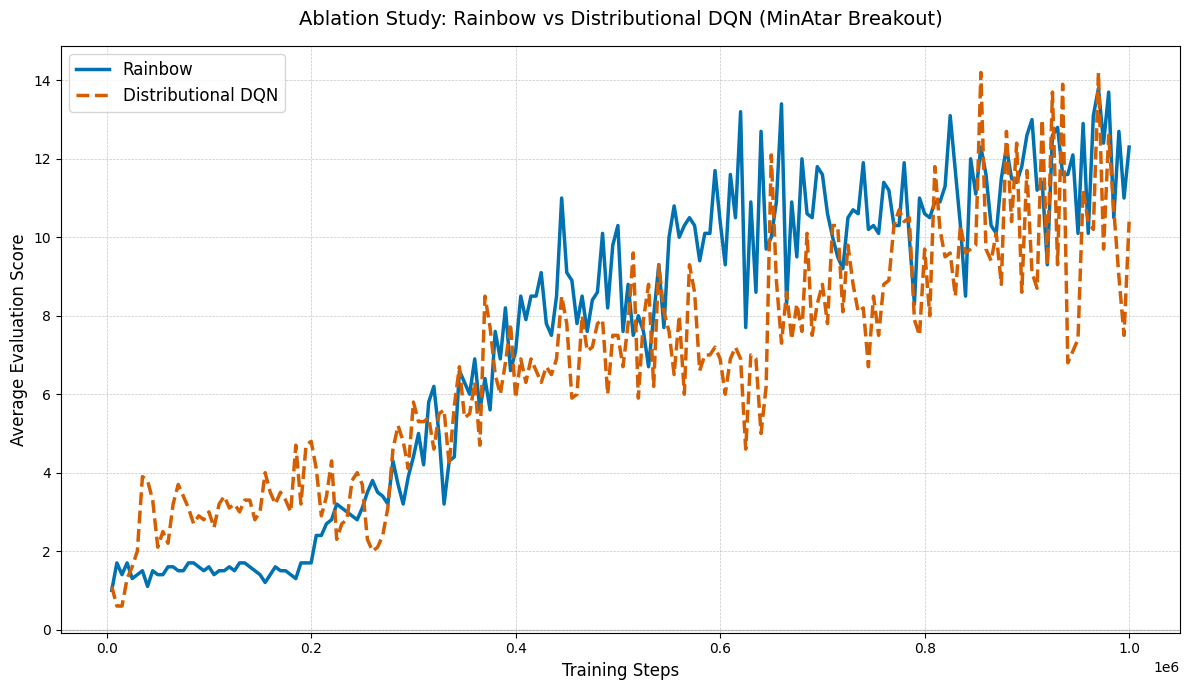

Comparison plot saved as 'rainbow_vs_distdqn_comparison.png'


In [23]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import os

# 1. Define paths to your result files
rainbow_path = 'results/minatar_test/metrics.pth'
dist_dqn_path = 'results/dist_dqn_baseline/metrics.pth'

def load_metrics(path, name):
    if not os.path.exists(path):
        print(f"Warning: Could not find {name} results at {path}")
        return None, None

    try:
        # Load data (map_location ensures it loads on CPU even if saved on GPU)
        metrics = torch.load(path, map_location=torch.device('cpu'))
        steps = metrics['steps']

        # 'rewards' is typically a list of lists (e.g., [[10, 12, 11], [13, 14, 12]...])
        # We calculate the mean for each evaluation point
        raw_rewards = metrics['rewards']
        if len(raw_rewards) > 0 and isinstance(raw_rewards[0], list):
            avg_rewards = [np.mean(r) for r in raw_rewards]
        else:
            avg_rewards = raw_rewards

        return steps, avg_rewards
    except Exception as e:
        print(f"Error reading {name} file: {e}")
        return None, None

# 2. Extract Data
steps_rain, rewards_rain = load_metrics(rainbow_path, "Rainbow")
steps_dist, rewards_dist = load_metrics(dist_dqn_path, "Distributional DQN")

# 3. Generate Plot
plt.figure(figsize=(12, 7))

# Plot Rainbow (Solid Blue Line)
if steps_rain:
    plt.plot(steps_rain, rewards_rain, label='Rainbow', color='#0072B2', linewidth=2.5)

# Plot Distributional DQN (Dashed Orange Line)
if steps_dist:
    plt.plot(steps_dist, rewards_dist, label='Distributional DQN', color='#D55E00', linewidth=2.5, linestyle='--')

# Styling for Scientific Publication
plt.title('Ablation Study: Rainbow vs Distributional DQN (MinAtar Breakout)', fontsize=14, pad=15)
plt.xlabel('Training Steps', fontsize=12)
plt.ylabel('Average Evaluation Score', fontsize=12)
plt.legend(fontsize=12, loc='upper left')
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.axhline(y=0, color='black', linewidth=1, alpha=0.2) # Zero line

# Tight layout handles padding automatically
plt.tight_layout()

# 4. Save and Show
plt.savefig('rainbow_vs_distdqn_comparison.png', dpi=300)
plt.show()

print("Comparison plot saved as 'rainbow_vs_distdqn_comparison.png'")